# **Milestone 1:**
Building an image classifier


### **Setting up the environment**

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# !pip install tensorflow==2.3.0

###**Importing the required modules**

In [3]:
# import libraries
import requests
import glob
from io import BytesIO
import os
import pathlib
import shutil
import json
import numpy as np

from pprint import pprint
import IPython.display as display

from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

from datetime import date
from datetime import datetime

In [4]:
print(tf.__version__)

2.3.0


In [5]:
print(tf.__version__)

2.3.0


In [6]:
# confirm that GPU is running
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

### **Getting the data**

In [8]:
DATA_DIR = '/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/data/food-101-subset/images'
DATA_DIR = pathlib.Path(DATA_DIR)

In [9]:
DATA_DIR


PosixPath('/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/data/food-101-subset/images')

###**Inspecting the dataset**

In [10]:
# print the folder names
!ls -lah {DATA_DIR}/ | head 

total 12K
drwx------ 2 root root 4.0K Sep 29 12:19 apple_pie
drwx------ 2 root root 4.0K Sep 29 12:19 caesar_salad
drwx------ 2 root root 4.0K Sep 29 12:19 falafel


In [11]:
# print the first five images in the first image folder
!ls {DATA_DIR}/apple_pie | head -5

1005649.jpg
1011328.jpg
101251.jpg
1014775.jpg
1026328.jpg


In [12]:
# number of total images in the database
image_count = len(list(DATA_DIR.glob('*/*.jpg')))
image_count

2752

In [13]:
# number of different classes
total_classes = sorted(np.array([item.name for item in DATA_DIR.glob('*')]))
print(len(total_classes))

3


In [14]:
# class names
total_classes

['apple_pie', 'caesar_salad', 'falafel']

### **Looking at images**

In [15]:
apple_pie = total_classes[0]

Image Size (w, h):  512 , 512
/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/data/food-101-subset/images/apple_pie/3670548.jpg


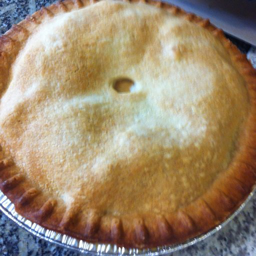

Image Size (w, h):  512 , 512
/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/data/food-101-subset/images/apple_pie/2518174.jpg


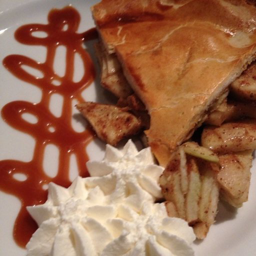

In [16]:
images = list(DATA_DIR.glob(f'{apple_pie}/*'))

for image_path in images[:2]:
    # resize image
    im = Image.open(str(image_path))
    w, h = im.size
    print('Image Size (w, h): ', w, ",",  h)
    print (image_path)
    percent_resize = 0.5
    im = im.resize((int(w*percent_resize), int(h*percent_resize)))
    display.display(im)

### **Preparing the dataset**


In [17]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)

In [18]:
print("Number of classes we are training: ", len(total_classes))
print("\nList of classes")
list(total_classes)

Number of classes we are training:  3

List of classes


['apple_pie', 'caesar_salad', 'falafel']

In [19]:
# using ImageDataGenerator to read images from directories
def get_image_data_generator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input):
    # create an instance of the ImageDataGenerator class for preprocessing
    image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        validation_split=0.2,
        preprocessing_function=preprocessing_function)

    # create an iterator for the images in the directory, which are organized into subdirectories according to their class.
    # train generator
    image_data_gen_train = image_generator.flow_from_directory(
        directory=str(DATA_DIR),
        batch_size=BATCH_SIZE,
        shuffle=True,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(total_classes),
        subset = 'training')
  
    # validation generator
    image_data_gen_val = image_generator.flow_from_directory(
        directory=str(DATA_DIR),
        batch_size=BATCH_SIZE,
        shuffle=False,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        classes = list(total_classes),
        subset = 'validation')

    return image_data_gen_train, image_data_gen_val

In [20]:
image_data_gen_train, image_data_gen_val = get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

Found 2202 images belonging to 3 classes.
Found 550 images belonging to 3 classes.


### **Saving the dataset**

In [21]:
# check number of classes
image_data_gen_train.num_classes

3

In [22]:
# convert dict to list
list_of_classes = list(image_data_gen_train.class_indices.keys())

In [23]:
# check class names
list_of_classes

['apple_pie', 'caesar_salad', 'falafel']

In [24]:
# save list of classes as `classes.json`
with open(f"/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/classes.json",'w') as f:
  json.dump(list_of_classes,f)

---

### **Model Architectures**

#### Model 1:  VGG19 (Baseline)

In [25]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# use VGG19 pretrained on ImageNet
base_layers_vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=IMAGE_SHAPE + (3,))

# add new layers to be finetuned
# the last layer is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf_vgg19 = tf.keras.Sequential([
    base_layers_vgg19
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen_train.num_classes , name='classification', activation='softmax')
])

In [26]:
clf_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 20,552,771
Trainable params: 20,552,771
Non-trainable params: 0
_________________________________________________________________


In [27]:
# freezes the base layers
base_layers_vgg19.trainable = False

In [28]:
# notice that after freezing the base layers, the non trainable params are equal to the number of parameters in the base layer 
clf_vgg19.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 20,552,771
Trainable params: 528,387
Non-trainable params: 20,024,384
_________________________________________________________________


In [29]:
# defining callbacks
callbacks = [
    tf.keras.callbacks.CSVLogger(str("/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/training_VGG19.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3,verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3,verbose = 1)
]

In [30]:
# set the model to use Adam optimizer, cross entropy loss, and track accuracy
clf_vgg19.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

##### Model results

In [31]:
# train the model for 3 epochs
%%time
# note the preprocessing function uses the preprocessing function for vgg19 (needs to be replaced for other models)
image_data_gen_train_vgg19, image_data_gen_val_vgg19 = get_image_data_generator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

history = clf_vgg19.fit(image_data_gen_train_vgg19,
                       epochs=3,
                       workers=8,
                       callbacks=callbacks,
                       validation_data=image_data_gen_val_vgg19 
                       )


Found 2202 images belonging to 3 classes.
Found 550 images belonging to 3 classes.
Epoch 1/3
69/69 [==============================] - 16s 227ms/step - loss: 1.5084 - acc: 0.8134 - val_loss: 0.3791 - val_acc: 0.9255
Epoch 2/3
69/69 [==============================] - 15s 216ms/step - loss: 0.2403 - acc: 0.9314 - val_loss: 0.2613 - val_acc: 0.9164
Epoch 3/3
69/69 [==============================] - 15s 214ms/step - loss: 0.1527 - acc: 0.9496 - val_loss: 0.2412 - val_acc: 0.9273
CPU times: user 1min 17s, sys: 6.03 s, total: 1min 23s
Wall time: 54.4 s


##### Save model

In [32]:
# save the model as `h5` format
export_path = "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/model_VGG19.h5"
export_path
clf_vgg19.save(export_path, save_format='h5')


#### Model 2:  ResNet50

In [33]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# use ResNet50 pretrained on ImageNet
base_layers_rn50 = tf.keras.applications.ResNet50(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE + (3,))

# add new layers to be finetuned
# the last layer is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf_rn50 = tf.keras.Sequential([
    base_layers_rn50
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen_train.num_classes , name='classification', activation='softmax')
])

In [34]:
clf_rn50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 25,688,963
Trainable params: 25,635,843
Non-trainable params: 53,120
_________________________________________________________________


In [35]:
# freeze the base layers
base_layers_rn50.trainable = False

In [36]:
clf_rn50.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 25,688,963
Trainable params: 2,101,251
Non-trainable params: 23,587,712
_________________________________________________________________


In [37]:
# set the model to use Adam optimizer, cross entropy loss, and track accuracy
clf_rn50.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

In [38]:
# defining callbacks
callbacks = [
    tf.keras.callbacks.CSVLogger(str("/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/training_ResNet50.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',patience = 3, verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)
]

##### Model results

In [39]:
# train the model for 3 epochs
%%time
# note the preprocessing function uses the preprocessing function for ResNet50
image_data_gen_train_rn50, image_data_gen_val_rn50 = get_image_data_generator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

history = clf_rn50.fit(image_data_gen_train_rn50,
                       epochs=3,
                       workers=8,
                       callbacks=callbacks,
                       validation_data=image_data_gen_val_rn50 
                       )


Found 2202 images belonging to 3 classes.
Found 550 images belonging to 3 classes.
Epoch 1/3
69/69 [==============================] - 17s 242ms/step - loss: 0.7380 - acc: 0.8193 - val_loss: 0.3194 - val_acc: 0.8909
Epoch 2/3
69/69 [==============================] - 15s 216ms/step - loss: 0.2030 - acc: 0.9228 - val_loss: 0.2179 - val_acc: 0.9182
Epoch 3/3
69/69 [==============================] - 14s 209ms/step - loss: 0.0983 - acc: 0.9632 - val_loss: 0.2483 - val_acc: 0.9218
CPU times: user 1min 19s, sys: 5.09 s, total: 1min 24s
Wall time: 55.3 s


##### Save model

In [40]:
# save the model as `h5` format
export_path = "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/model_ResNet50.h5"
export_path
clf_rn50.save(export_path, save_format='h5')


#### Model 3: MobileNetV2

In [41]:
IMAGE_SHAPE = (IMG_HEIGHT, IMG_WIDTH)

# use ResNet50 pretrained on ImageNet
base_layers_mnv2 = tf.keras.applications.MobileNetV2(weights='imagenet',include_top=False,input_shape=IMAGE_SHAPE + (3,))

# add new layers to be finetuned
# the last layer is the classification layer and should match the number of classes in the dataset. The activation should be softmax 
clf_mnv2 = tf.keras.Sequential([
    base_layers_mnv2
    , tf.keras.layers.GlobalAveragePooling2D()
    , tf.keras.layers.Dense(1024, activation='relu')
    , tf.keras.layers.Dense(image_data_gen_train.num_classes , name='classification', activation='softmax')
])

In [42]:
clf_mnv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 3,538,691
Non-trainable params: 34,112
_________________________________________________________________


In [43]:
# freeze the base layers
base_layers_mnv2.trainable = False

In [44]:
clf_mnv2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 1,314,819
Non-trainable params: 2,257,984
_________________________________________________________________


In [45]:
# defining callbacks
callbacks = [
    tf.keras.callbacks.CSVLogger(str("/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/training_MobileNetV2.log"))
    ,tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1)
    ,tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1)
]

In [46]:
# set the model to use Adam optimizer, cross entropy loss, and track accuracy
clf_mnv2.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy' ,
  metrics=['acc'])

##### Model results

In [47]:
# train the model for 3 epochs
%%time
# note the preprocessing function uses the preprocessing function for MobileNetV2
image_data_gen_train_mnv2, image_data_gen_val_mnv2 = get_image_data_generator(preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input)

history = clf_mnv2.fit(image_data_gen_train_mnv2,
                       epochs=3,
                       workers=8,
                       callbacks=callbacks,
                       validation_data=image_data_gen_val_mnv2 
                       )


Found 2202 images belonging to 3 classes.
Found 550 images belonging to 3 classes.
Epoch 1/3
69/69 [==============================] - 15s 219ms/step - loss: 0.3888 - acc: 0.8574 - val_loss: 0.2719 - val_acc: 0.9055
Epoch 2/3
69/69 [==============================] - 13s 192ms/step - loss: 0.1192 - acc: 0.9555 - val_loss: 0.2766 - val_acc: 0.8982
Epoch 3/3
69/69 [==============================] - 13s 194ms/step - loss: 0.0660 - acc: 0.9782 - val_loss: 0.2472 - val_acc: 0.9164
CPU times: user 1min 9s, sys: 4.92 s, total: 1min 14s
Wall time: 48.9 s


##### Save model

In [48]:
# save the model as `h5` format
export_path = "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/model_MobileNetV2.h5"
export_path
clf_mnv2.save(export_path, save_format='h5')


### **Fine tune model *(optional)***

The model accuracy can be further improved by 
- unfreezing the early layers, use [transfer learning](https://www.tensorflow.org/guide/keras/transfer_learning)
- use [data augmentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

### **Model Comparison**

In [49]:
# get the models directory
! du -h "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts"

221M	/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts


In [50]:
# list all stored models
!ls "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts" -lah

total 221M
-rw------- 1 root root   40 Oct 24 06:52 classes.json
-rw------- 1 root root  24M Oct 24 06:55 model_MobileNetV2.h5
-rw------- 1 root root 115M Oct 24 06:54 model_ResNet50.h5
-rw------- 1 root root  83M Oct 24 06:53 model_VGG19.h5
-rw------- 1 root root  272 Oct 24 06:55 training_MobileNetV2.log
-rw------- 1 root root  270 Oct 24 06:54 training_ResNet50.log
-rw------- 1 root root  275 Oct 24 06:53 training_VGG19.log


- Dataset:  Food
- Classes: 3
- Total images: 3000
- Batch size: 32

| Model  | Trainable Params| Non-trainable Params | Time (hh:mm:ss)| Accuracy | Epochs | Model Size
|---|---:|---:|---:|---:| ---:|---:|
| VGG19| 528,387   | 20,024,384 | 00:01:18 | 96.2% | 3 | 83M
| ResNet50   | 2,101,251   | 23,587,712 |  00:01:37 | 96.2% | 3 | 114M
| MobileNetV2  | 1,314,819  | 2,257,984 |   00:01:27 | 97.5% | 3 | 24M



### **Model Prediction**

In [51]:
model_path_mnv2 = "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/model_MobileNetV2.h5"
clf_final = tf.keras.models.load_model(model_path_mnv2)

In [52]:
with open(f"/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/artifacts/classes.json",'r') as f:
  list_of_classes = json.load(f)
  #content = f.read()

In [53]:
list_of_classes

['apple_pie', 'caesar_salad', 'falafel']

In [54]:
# create a sub-directory for data
!mkdir -p "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image"

In [55]:
!wget https://natashaskitchen.com/wp-content/uploads/2019/01/Caesar-Salad-Recipe-3.jpg -P "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image" -O "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/caesar_salad.jpg"

--2021-10-24 06:55:10--  https://natashaskitchen.com/wp-content/uploads/2019/01/Caesar-Salad-Recipe-3.jpg
Resolving natashaskitchen.com (natashaskitchen.com)... 104.22.26.177, 172.67.39.135, 104.22.27.177, ...
Connecting to natashaskitchen.com (natashaskitchen.com)|104.22.26.177|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173804 (170K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/caesar_salad.jpg’

caesar_salad.jpg    100%[===================>] 169.73K  --.-KB/s    in 0.01s   

2021-10-24 06:55:10 (12.1 MB/s) - ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/caesar_salad.jpg’ saved [173804/173804]



In [56]:
!wget https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg -P "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image" -O "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/black_square.jpg"

--2021-10-24 06:55:10--  https://upload.wikimedia.org/wikipedia/commons/9/99/Black_square.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5450 (5.3K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/black_square.jpg’

black_square.jpg    100%[===================>]   5.32K  --.-KB/s    in 0s      

2021-10-24 06:55:10 (160 MB/s) - ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/black_square.jpg’ saved [5450/5450]



In [57]:
!wget https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg -P "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image" -O "/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/table.jpg"


--2021-10-24 06:55:10--  https://image.shutterstock.com/image-photo/brown-light-wooden-round-dining-260nw-588358070.jpg
Resolving image.shutterstock.com (image.shutterstock.com)... 52.222.158.123, 52.222.158.30, 52.222.158.51, ...
Connecting to image.shutterstock.com (image.shutterstock.com)|52.222.158.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11954 (12K) [image/jpeg]
Saving to: ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/table.jpg’

table.jpg           100%[===================>]  11.67K  --.-KB/s    in 0s      

2021-10-24 06:55:10 (55.2 MB/s) - ‘/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/table.jpg’ saved [11954/11954]



In [58]:
img_path = f"/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/caesar_salad.jpg"
#img_path = f"/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/table.jpg"
#img_path = f"/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/black_square.jpg"

img_path

'/content/drive/MyDrive/ImageClassifierasWebandMobileApplication/test_image/caesar_salad.jpg'

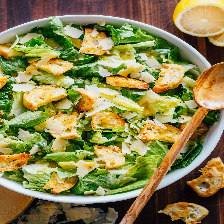

In [59]:
# load the image
tf.keras.preprocessing.image.load_img(img_path, target_size = (IMG_HEIGHT, IMG_WIDTH))

In [60]:
def load_img_predict(img_path):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)

    img = np.expand_dims(img, axis=0)
    
    return img

In [61]:
clf_final.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
classification (Dense)       (None, 3)                 3075      
Total params: 3,572,803
Trainable params: 1,314,819
Non-trainable params: 2,257,984
_________________________________________________________________


In [62]:
def predict_image(img_path, classifier):
    img = load_img_predict(img_path)
    pred = clf_final.predict(img)

    pred = sorted(list(zip(list_of_classes, np.squeeze(pred))), key=lambda x:x[1], reverse=True)
    
    return pred

In [63]:
# predict the class for the given image
predict_image(img_path, clf_final)

[('caesar_salad', 0.99966455),
 ('falafel', 0.00030338336),
 ('apple_pie', 3.2011034e-05)]